# Data Preprocessing

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset 
data = pd.read_csv('ExioML_factor_accounting_IxI.csv')

In [32]:
data = data.loc[:, ~data.columns.str.contains('^Unnamed: 0')]
data['Year'] = pd.to_datetime(data['Year'],format='%Y')
data.head()

,region,sector,Value Added [M.EUR],Employment [1000 p.],GHG emissions [kg CO2 eq.],Energy Carrier Net Total [TJ],Year
0,AT,Cultivation of wheat,NaN,13.187442,NaN,2070.0,1995-01-01
1,AT,Cultivation of cereal grains nec,402.230580,25.673157,NaN,3640.0,1995-01-01
2,AT,"Cultivation of vegetables, fruit, nuts",830.212738,48.616948,2.389458e+08,2975.0,1995-01-01
3,AT,Cultivation of oil seeds,101.970543,2.867099,1.197554e+08,265.0,1995-01-01
4,AT,"Cultivation of sugar cane, sugar beet",NaN,3.142473,7.751692e+07,220.0,1995-01-01


In [33]:
data.info()
print('\nThe missing values in feature:\n',data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179185 entries, 0 to 179184
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   region                         179185 non-null  object        
 1   sector                         166583 non-null  object        
 2   Value Added [M.EUR]            143098 non-null  float64       
 3   Employment [1000 p.]           161311 non-null  float64       
 4   GHG emissions [kg CO2 eq.]     125766 non-null  float64       
 5   Energy Carrier Net Total [TJ]  179185 non-null  float64       
 6   Year                           170172 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 9.6+ MB

The missing values in feature:
 region                               0
sector                           12602
Value Added [M.EUR]              36087
Employment [1000 p.]             17874
GHG emissions [kg 

In [34]:
# Calculate the percentage of missing values in each column
missing_percentage = data.isnull().mean() * 100

# Create a DataFrame to show the results more clearly
missing_df = pd.DataFrame({
    'Column': data.columns,
    'Missing Percentage (%)': missing_percentage
})

missing_df.reset_index(drop=True, inplace=True)

# Display the missing percentage for each column
missing_df

,Column,Missing Percentage (%)
0,region,0.000000
1,sector,7.032955
2,Value Added [M.EUR],20.139521
3,Employment [1000 p.],9.975165
4,GHG emissions [kg CO2 eq.],29.812205
5,Energy Carrier Net Total [TJ],0.000000
6,Year,5.029997


### Handling missing values

In [35]:
# Imputation or Deletion

# Drop rows where 'GHG emissions' are missing (could be critical data)
df_cleaned = data.dropna(subset=['GHG emissions [kg CO2 eq.]']).copy()

# Find the most frequent sector (mode)
most_frequent_sector = data['sector'].mode()[0]

# Replace missing values in the 'sector' column with the most frequent sector
df_cleaned.loc[:, 'sector'] = df_cleaned['sector'].fillna(most_frequent_sector)

# Impute missing values in 'Value Added' and 'Employment' with the mean
df_cleaned.loc[:, 'Value Added [M.EUR]'] = df_cleaned['Value Added [M.EUR]'].fillna(df_cleaned['Value Added [M.EUR]'].mean())
df_cleaned.loc[:, 'Employment [1000 p.]'] = df_cleaned['Employment [1000 p.]'].fillna(df_cleaned['Employment [1000 p.]'].mean())

# Impute missing values in 'Year' using forward fill (ffill)
df_cleaned.loc[:, 'Year'] = df_cleaned['Year'].fillna(method='ffill')
# df_cleaned['Year'] = df_cleaned['Year'].astype(int)

/var/folders/vs/03bk43jj4jn9ptfvw49_hbv80000gn/T/ipykernel_19271/3042328903.py:17: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_cleaned.loc[:, 'Year'] = df_cleaned['Year'].fillna(method='ffill')


1. **GHG emissions [kg CO2 eq.]**
   - **Operation**: Rows with missing values are dropped.
   - **Purpose**: This column is critical for analysis, so any rows missing GHG emissions data are removed to maintain data integrity.

2. **sector**
   - **Operation**: Missing values are imputed with the most frequent sector (mode).
   - **Purpose**: To ensure all entries have a valid sector designation, the most common sector is used to fill in any missing values.

3. **Value Added [M.EUR]**
   - **Operation**: Missing values are imputed with the mean value of the column.
   - **Purpose**: This maintains a statistical representation of the dataset by replacing missing values with the average, allowing for better analysis without losing data points.

4. **Employment [1000 p.]**
   - **Operation**: Missing values are imputed with the mean value of the column.
   - **Purpose**: Similar to the `Value Added` column, imputing with the mean ensures that the dataset remains intact while maintaining the overall distribution of employment data.

5. **Year**
   - **Operation**: Missing values are imputed using forward fill (ffill).
   - **Purpose**: This method fills missing year entries with the last observed year, which can help maintain chronological continuity in the dataset.

These operations aim to enhance data quality, ensuring that the dataset is clean and ready for further analysis while minimizing the impact of missing values.

In [36]:
# Display the missing percentage for each column
df_cleaned.isna().sum()

region                           0
sector                           0
Value Added [M.EUR]              0
Employment [1000 p.]             0
GHG emissions [kg CO2 eq.]       0
Energy Carrier Net Total [TJ]    0
Year                             0
dtype: int64

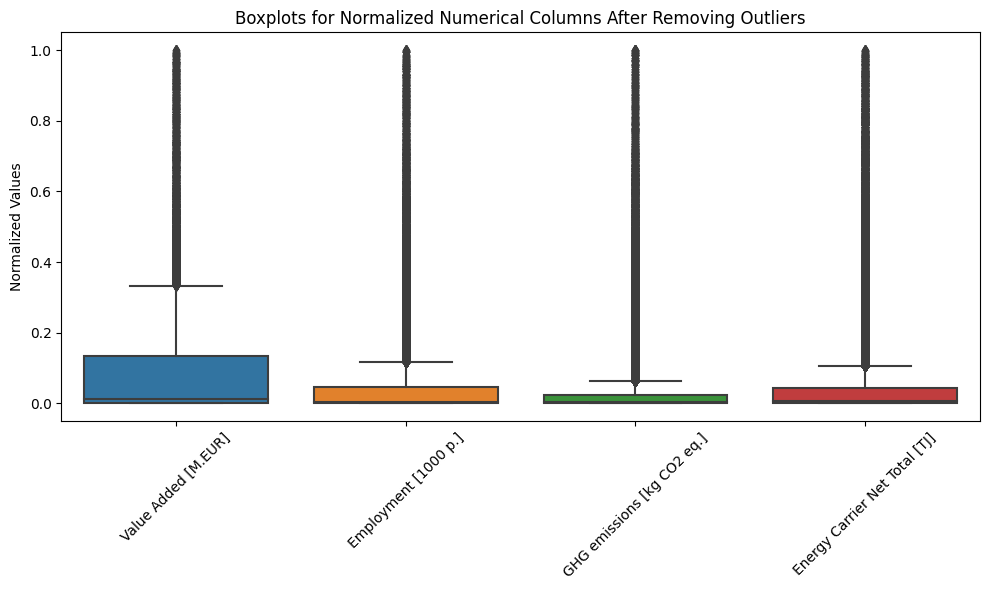

In [37]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Function to detect and remove outliers based on IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.05)
        Q3 = df[col].quantile(0.95)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Apply outlier removal on numerical columns
numerical_columns = ['Value Added [M.EUR]', 'Employment [1000 p.]', 'GHG emissions [kg CO2 eq.]', 'Energy Carrier Net Total [TJ]']
df_no_outliers = remove_outliers(df_cleaned, numerical_columns)

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_no_outliers[numerical_columns]), columns=numerical_columns)

# Plot boxplots for the normalized data
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_normalized)
plt.title('Boxplots for Normalized Numerical Columns After Removing Outliers')
plt.xticks(rotation=45)
plt.ylabel('Normalized Values')
plt.tight_layout()
plt.show()

In [38]:
df_no_outliers.reset_index(drop=True,inplace=True)

In [39]:
df_no_outliers.shape

(115471, 7)

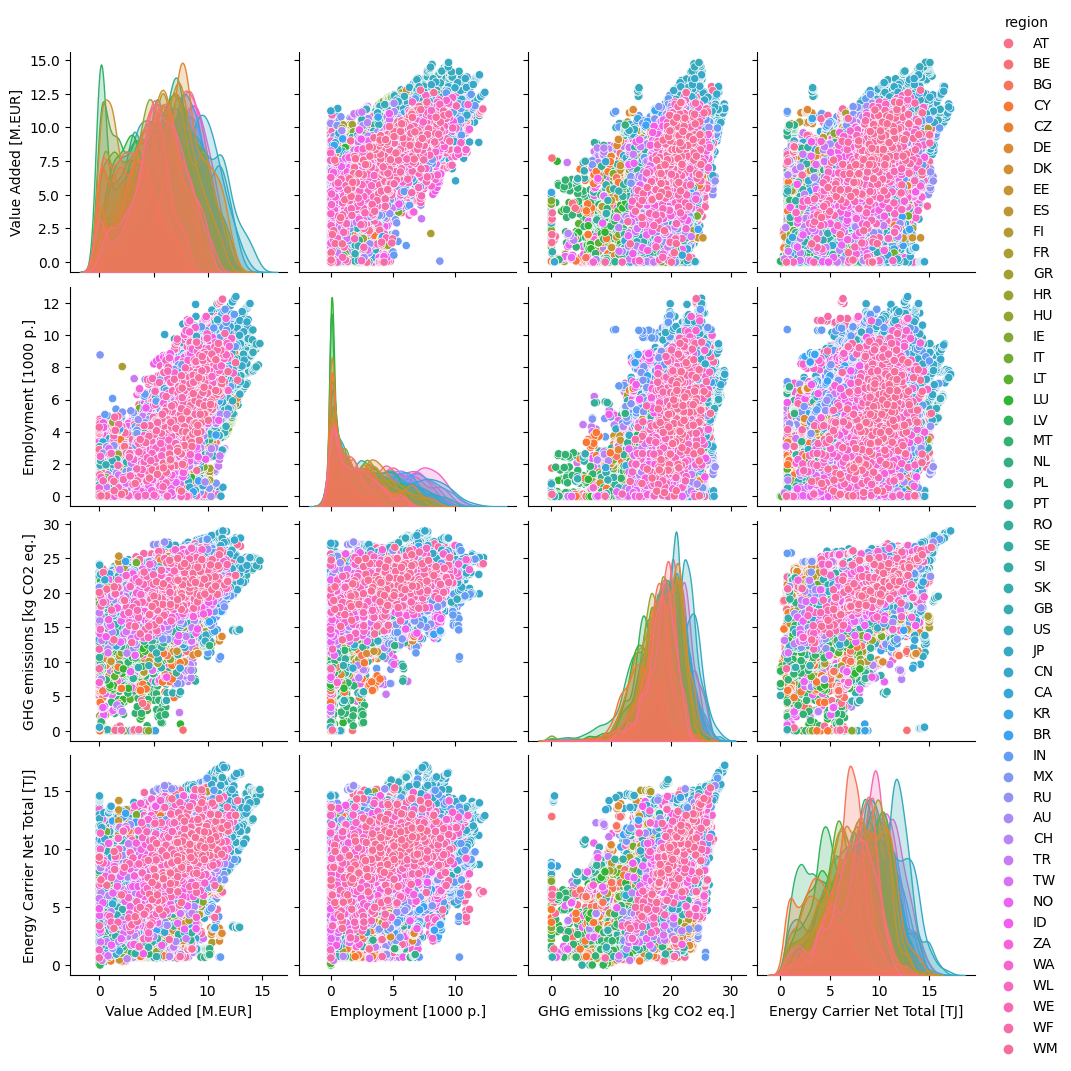

In [40]:
# apply log scaling transformation and plotting pair plots

columns_to_log = data.columns[2:6]

data[columns_to_log] = data[columns_to_log].apply(lambda x: np.log1p(x))

# Create a pair plot with the log-scaled data
sns.pairplot(data, hue='region')

# Show the plot
plt.show()

This image shows a pair plot, a type of data visualization used to explore the relationships between multiple variables. Each subfigure in this plot gives different insights into the relationships between sectors across several factors, with each point color-coded to represent a specific region.

### Breakdown of the Plot:

1. **Diagonal Subfigures:**
   The diagonal subfigures show the distribution for each variable. The variables along the diagonal are:
   - Value Added [M EUR]
   - Employment [1000 people]
   - GHG (Greenhouse Gas) Emissions [kg CO2 eq.]
   - Energy Carrier Net Total [TJ]
   - Year (ranging from 1995 to 2020)

   These plots give an overview of how these metrics are distributed within sectors for the regions listed in the legend (countries like AT, BE, etc.).

2. **Off-Diagonal Subfigures:**
   The off-diagonal subfigures are scatter plots, showing pairwise relationships between the variables. Each plot represents the relationship between two variables, where:
   - Each point represents a sector.
   - The color corresponds to the region of that sector (e.g., Austria, Belgium, etc.).

3. **Color Coding:**
   The colors correspond to specific regions or countries, allowing for regional analysis. For example, you can see how different countries contribute to these variables across sectors. The legend to the right includes two-letter country codes (e.g., AT for Austria, BE for Belgium, etc.).

### Key Insights:
- The plot reveals high pairwise correlations between the variables. For example, sectors with high value-added tend to employ more people and generate more GHG emissions, implying a relationship between economic growth, employment, and environmental impact.
- The temporal analysis (Year vs. other variables) shows how the distribution of these factors has evolved from 1995 to 2020, indicating trends like growth in emissions and employment over time.
- Regions are spread across these variables, offering insights into how specific regions may have higher emissions, value added, or energy consumption than others.

In [41]:
df_no_outliers.to_csv('dataset.csv',index=False)